# QAM Final Project_Hidden Markov Model

**Junho Kim, Yunjia Zhang, Xiaotian Wang, Yvonne Zhang**


In [118]:
#Package
import os
os.environ["OMP_NUM_THREADS"] = "2"

import pandas as pd
import numpy as np
import pandas_datareader.data as web
import wrds

#HMM
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM

#Graph
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#Regression
import statsmodels.api as sm

In [137]:
# -----------------------------
# Performance Evaluation Metrics
# -----------------------------

def sharpe_ratio(returns, periods_per_year=12):
    """
    Calculates the annualized Sharpe Ratio.
    Sharpe = (mean return / std dev) * sqrt(periods per year)
    """
    return (returns.mean() / returns.std()) * np.sqrt(periods_per_year)

def sortino_ratio(returns, periods_per_year=12):
    """
    Calculates the annualized Sortino Ratio.
    Only penalizes downside volatility (returns < 0).
    """
    downside_std = returns[returns < 0].std()
    return (returns.mean() / downside_std) * np.sqrt(periods_per_year)

def max_drawdown(cum_returns):
    """
    Computes the maximum drawdown from cumulative returns.
    """
    roll_max = cum_returns.cummax()
    drawdown = abs(roll_max - cum_returns)/roll_max
    max_dd = drawdown.max()
    return -max_dd
    
def win_rate(returns):
    """
    Calculates the proportion of periods with positive returns.
    """
    return (returns > 0).mean()

def gain_to_pain(returns):
    """
    Measures return-to-risk as total return over total absolute losses.
    """
    return returns.sum() / returns.abs().sum()

def annualized_return(returns, periods_per_year=12):
    """
    Computes annualized return from average periodic return.
    Assumes returns are in percentage terms (e.g., 1.5 means 1.5%).
    """
    return (1 + returns.mean()/100) ** periods_per_year - 1

def annualized_volatility(returns, periods_per_year=12):
    """
    Computes annualized volatility.
    Assumes returns are in percentage terms (e.g., 1.5 means 1.5%).
    """
    return returns.std() * np.sqrt(periods_per_year) / 100

def performance_metrics(returns, periods_per_year=12):
    """
    Aggregates various performance metrics into a dictionary.
    Expects returns in decimal form (e.g., 0.01 for 1%).
    """
    
    cum_returns = np.log1p(df['rtn'] / 100).cumsum()
    cum_returns = cum_returns.replace([np.inf, -np.inf], np.nan).dropna()
    metrics = {
        'Annual Return': annualized_return(returns, periods_per_year),
        'Annual Volatility': annualized_volatility(returns, periods_per_year),
        'Sharpe': sharpe_ratio(returns, periods_per_year),
        'Sortino': sortino_ratio(returns, periods_per_year),
        'Max Drawdown': max_drawdown(cum_returns),
        'Win Rate': win_rate(returns),
        'Gain-to-Pain': gain_to_pain(returns)
    }
    return metrics

# -----------------------------
# Regime-based Weighting Strategy
# -----------------------------

def winner_weight(state):
    """
    Determines the weight assigned to 'winner' portfolio depending on regime state.
    """
    if state == 0:   # Neutral
        return -0.5
    elif state == 1: # Recession
        return -0.5
    elif state == 2: # Normal
        return 1
    elif state == 3: # Recovery
        return 0.5
    else:
        return None  # Handle undefined states

def loser_weight(state):
    """
    Determines the weight assigned to 'loser' portfolio depending on regime state.
    """
    if state == 0:   # Neutral
        return 0.5
    elif state == 1: # Recession
        return 0
    elif state == 2: # Normal
        return -1
    elif state == 3: # Recovery
        return -1
    else:
        return None  # Handle undefined states

### Column Descriptions

| Column        | Description |
|---------------|-------------|
| `Date`        | Observation date (typically end of month), format: `YYYY-MM-DD` |
| `GS10`        | 10-Year U.S. Treasury yield (constant maturity), from FRED |
| `GS2`         | 2-Year U.S. Treasury yield (constant maturity) |
| `GS3M`        | 3-Month U.S. Treasury yield (constant maturity). For dates prior to 1981-09, the **TB3MS** series (3-Month Treasury Bill Secondary Market Rate, Discount Basis) was converted to a yield-equivalent rate and used as a proxy. |
| `Year`        | Calendar year extracted from `Date` |
| `Month`       | Calendar month extracted from `Date` |
| `SP10-2`      | Term spread: 10Y yield − 2Y yield (indicator of yield curve slope) |
| `SP10-3M`     | Term spread: 10Y yield − 3M yield (common recession predictor) |
| `realized_vol`| Realized volatility of S&P 500 over the month (e.g., √Σ daily return²) |
| `TEDRATE`     | TED Spread: 3M LIBOR − 3M Treasury rate (proxy for credit risk). |
| `UMCSENT`     | University of Michigan Consumer Sentiment Index (confidence indicator) |
| `PCE(MoM)`    | Personal Consumption Expenditure, month-over-month % change (inflation proxy) |
| `ICSA(Chg)`   | Initial Jobless Claims – weekly change (labor market stress indicator) |
| `D1`          | Decile 1 return (worst past performers, “losers”) |
| `D2` to `D9`  | Intermediate decile portfolio returns |
| `D10`         | Decile 10 return (best past performers, “winners”) |
| `MOM`         | Momentum strategy return, typically `D10 − D1` (WML: winner minus loser) |

For dates prior to 1986, the spread was approximated as **CP3M − GS3M**, using commercial paper rates. After the TED spread series was discontinued in 2022, the spread was proxied using **90-Day AA Financial Commercial Paper Interest Rate (RIFSPPFAAD90NB) − GS3M**. 

state
2    1.662443
0    1.833133
3    2.714128
1    2.995417
Name: rtn, dtype: float64


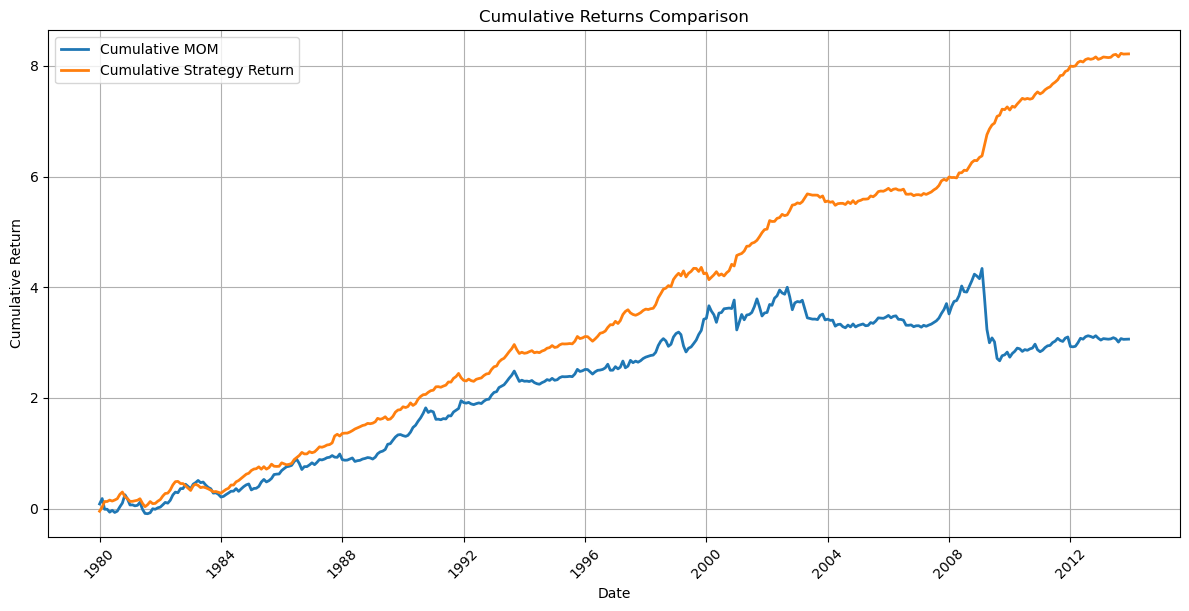

{'Annual Return': 0.2880179127449711, 'Annual Volatility': 0.1551150649085279, 'Sharpe': 1.649050962327003, 'Sortino': 2.941112367014405, 'Max Drawdown': -0.880608426728398, 'Win Rate': 0.7230392156862745, 'Gain-to-Pain': 0.5629257810098028}
state
2    0.637414
0    2.646167
1    3.195000
3    3.576607
Name: rtn, dtype: float64


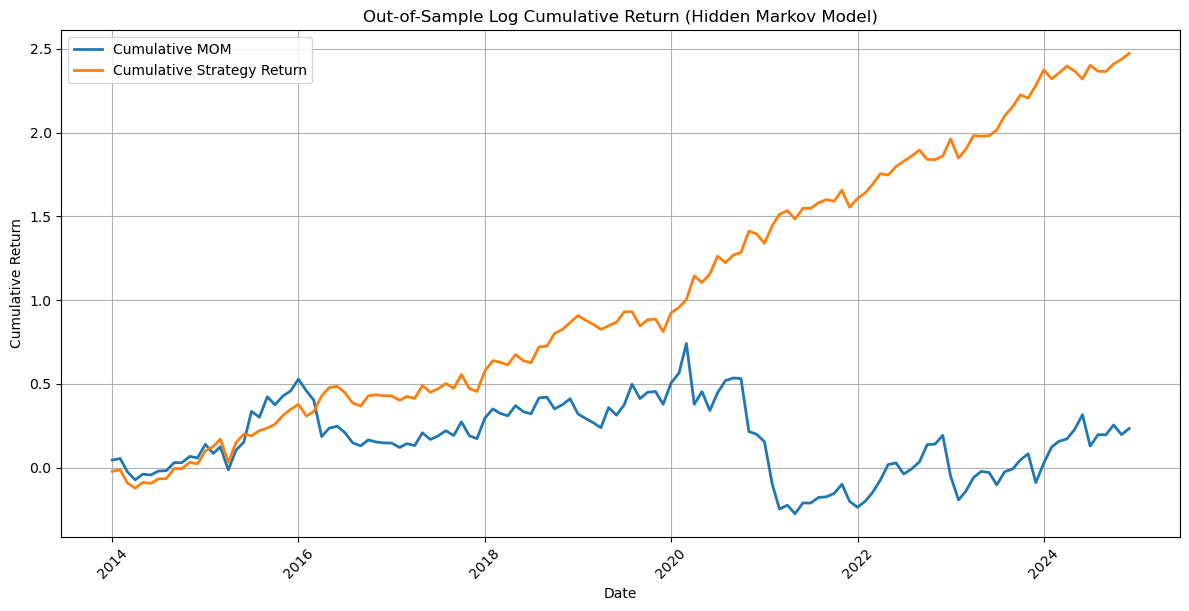

{'Annual Return': 0.2723396826333082, 'Annual Volatility': 0.1825203230154688, 'Sharpe': 1.3329524354955797, 'Sortino': 2.3100196290162236, 'Max Drawdown': -0.8176043493944212, 'Win Rate': 0.6363636363636364, 'Gain-to-Pain': 0.44857525980556484}


In [224]:
# Load data
data = pd.read_pickle('data_Junho.pkl')

# Split data into training (1980–2013) and testing (2014–2024) periods
train = data[(data['Date'] >= '1980-01-01') & (data['Date'] < '2014-01-01')]
test = data[(data['Date'] >= '2014-01-01') & (data['Date'] < '2025-01-01')]

# Drop missing values and reset index
train = train.dropna().reset_index(drop=True)
test = test.dropna().reset_index(drop=True)

# Select features to normalize
cols_to_normalize = ['GS10', 'GS2', 'GS3M', 'SP10-2', 'SP10-3M', 'realized_vol', 'TEDRATE',
                     'UMCSENT', 'PCE(MoM)', 'ICSA(Chg)', 'D1','D2', 'D3', 'D4', 'D5',
                     'D6', 'D7', 'D8', 'D9', 'D10', 'MOM']

# Standardize features using Z-score normalization
scaler = StandardScaler()
train_X = train.copy()
test_X = test.copy()
train_X[cols_to_normalize] = scaler.fit_transform(train_X[cols_to_normalize])
test_X[cols_to_normalize] = scaler.fit_transform(test_X[cols_to_normalize])  # NOTE: For realistic out-of-sample, use scaler.transform() not fit_transform()

# Reduce to standardized features only
train_X = train_X[cols_to_normalize]
test_X = test_X[cols_to_normalize]

# Fit Gaussian HMM with 4 hidden states
model = GaussianHMM(n_components=4, n_iter=2000, random_state=42)
model.fit(train_X)

# Predict regimes for training data
states = model.predict(train_X)

# Assign state and calculate regime-based strategy return
strat = train.copy()
strat['state'] = states
strat['winner'] = strat['state'].apply(winner_weight)
strat['loser'] = strat['state'].apply(loser_weight)
strat['rtn'] = strat['winner'] * strat['D10'] + strat['loser'] * strat['D1']

# Display average return by regime
print(strat.groupby('state')['rtn'].mean().sort_values())

# Compute cumulative log returns for MOM and strategy
df = strat.dropna(subset=['MOM', 'rtn'])
df['cum_MOM'] = np.log1p(df['MOM'] / 100).cumsum()
df['cum_rtn'] = np.log1p(df['rtn'] / 100).cumsum()
train_df = df.copy()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['cum_MOM'], label='Cumulative MOM', linewidth=2)
plt.plot(df['Date'], df['cum_rtn'], label='Cumulative Strategy Return', linewidth=2)
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Evaluate strategy performance on training set
print(performance_metrics(df['rtn']))

# Predict regimes on test set
states = model.predict(test_X)

# Construct test strategy DataFrame with predicted state
strat = test.copy()
strat['state'] = states
strat['winner'] = strat['state'].apply(winner_weight)
strat['loser'] = strat['state'].apply(loser_weight)
strat['rtn'] = strat['winner'] * strat['D10'] + strat['loser'] * strat['D1']

# Display average return by regime (test)
print(strat.groupby('state')['rtn'].mean().sort_values())

# Compute cumulative log returns for test period
df = strat.dropna(subset=['MOM', 'rtn'])
df['cum_MOM'] = np.log1p(df['MOM'] / 100).cumsum()
df['cum_rtn'] = np.log1p(df['rtn'] / 100).cumsum()
test_df = df.copy()

# Plot cumulative returns for test period
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['cum_MOM'], label='Cumulative MOM', linewidth=2)
plt.plot(df['Date'], df['cum_rtn'], label='Cumulative Strategy Return', linewidth=2)
plt.title('Out-of-Sample Log Cumulative Return (Hidden Markov Model)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Evaluate strategy performance on test set
print(performance_metrics(df['rtn']))

# Load Fama-French 3-Factor data
ff3 = pd.read_csv('./F-F_Research_Data_Factors.csv', skiprows=3)
ff3 = ff3.iloc[:1185, :]
ff3 = ff3.rename(columns={"Unnamed: 0": "Date"})
ff3['Date'] = ff3['Date'].astype(str)
ff3['Year'] = ff3['Date'].str[:4].astype(int)
ff3['Month'] = ff3['Date'].str[4:6].astype(int)

# Filter for overlap with strategy sample
ff3 = ff3[(ff3['Date'] >= '198001') & (ff3['Date'] < '202501')]
ff3[['Mkt-RF', 'SMB', 'HML', 'RF']] = ff3[['Mkt-RF', 'SMB', 'HML', 'RF']].astype(float)

# Merge factors into training/test DataFrames
train_df = pd.merge(train_df, ff3[['Year', 'Month', 'Mkt-RF', 'SMB', 'HML', 'RF']], on=['Year', 'Month'], how='left')
test_df = pd.merge(test_df, ff3[['Year', 'Month', 'Mkt-RF', 'SMB', 'HML', 'RF']], on=['Year', 'Month'], how='left')

# Calculate excess returns for regression (strategy return - risk-free rate)
train_df['ex_rtn'] = train_df['rtn'] - train_df['RF']
test_df['ex_rtn'] = test_df['rtn'] - test_df['RF']


In [126]:
train_df['cum_rtn']

0     -0.045678
1      0.028455
2      0.129386
3      0.129536
4      0.154863
         ...   
403    8.164336
404    8.227029
405    8.213539
406    8.214838
407    8.217235
Name: cum_rtn, Length: 408, dtype: float64

In [ ]:
#Train Set
df = train_df.copy()
X = df[['Mkt-RF', 'SMB', 'HML', 'MOM']]
X = sm.add_constant(X)  # adds intercept term for alpha
y = df['ex_rtn']
model = sm.OLS(y, X).fit()
alpha = model.params['const']
print(f"Estimated annualized alpha: {(alpha/100 + 1)**12 - 1:.6f} per period")
print(model.summary())

In [81]:
df = test_df.copy()
X = df[['Mkt-RF', 'SMB', 'HML', 'MOM']]
X = sm.add_constant(X)  # adds intercept term for alpha
y = df['ex_rtn']
model = sm.OLS(y, X).fit(cov_type='HC3')
alpha = model.params['const']
print(f"Estimated annualized alpha: {(alpha/100 + 1)**12 - 1:.6f} per period")
print(model.summary())

Estimated annualized alpha: 0.256725 per period
                            OLS Regression Results                            
Dep. Variable:                 ex_rtn   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.5406
Date:                Sun, 01 Jun 2025   Prob (F-statistic):              0.706
Time:                        18:57:12   Log-Likelihood:                -405.03
No. Observations:                 132   AIC:                             820.1
Df Residuals:                     127   BIC:                             834.5
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cons

In [196]:
df = pd.read_pickle('data_Logistic.pkl').T.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df.columns = ['Date','Train','Test','Year','Month']
logistic_train = df[['Year','Month','Train']].dropna().reset_index(drop=True)
logistic_test = df[['Year','Month','Test']].dropna().reset_index(drop=True)

In [214]:
logistic_train

,Year,Month,Train
0,1980,1,0.111197
1,1980,2,0.202156
2,1980,3,0.295796
3,1980,4,0.286602
4,1980,5,0.250579
...,...,...,...
403,2013,8,7.026570
404,2013,9,7.104112
405,2013,10,7.065228
406,2013,11,7.052020


In [198]:
df = pd.read_pickle('data_KNN.pkl').T.reset_index()
df['Year'] = df['index'].dt.year
df['Month'] = df['index'].dt.month
df.columns = ['Date','Train','Test','Year','Month']
knn_train = df[['Year','Month','Train']].dropna().reset_index(drop=True)
knn_test = df[['Year','Month','Test']].dropna().reset_index(drop=True)

In [204]:
df = pd.read_pickle('data_dc.pkl').T.reset_index()
df['Year'] = df['index'].dt.year
df['Month'] = df['index'].dt.month
df.columns = ['Date','Train','Test','Year','Month']
dc_train = df[['Year','Month','Train']].dropna().reset_index(drop=True)
dc_test = df[['Year','Month','Test']].dropna().reset_index(drop=True)

In [228]:
train_total = train_df.copy()
train_total = train_total.merge(logistic_train,on=['Year','Month'],how='left')
train_total = train_total.merge(knn_train,on=['Year','Month'],how='left')
train_total = train_total.merge(dc_train,on=['Year','Month'],how='left')
train_total = train_total.rename(columns={
    'Train_x': 'Logistic',
    'Train_y': 'KNN',
    'Train': 'DC_Bayes'
})
train_total

,Date,GS10,GS2,GS3M,Year,Month,SP10-2,SP10-3M,realized_vol,TEDRATE,...,cum_MOM,cum_rtn,Mkt-RF,SMB,HML,RF,ex_rtn,Logistic,KNN,DC_Bayes
0,1980-01-01,10.80,11.50,12.375387,1980,1,-0.70,-1.575387,0.042787,1.661533,...,0.085535,-0.045678,5.50,1.62,1.85,0.80,-5.265,0.111197,0.130783,0.055213
1,1980-02-01,12.41,13.42,13.292089,1980,2,-1.01,-0.882089,0.039529,1.219778,...,0.182934,0.028455,-1.23,-1.86,0.59,0.89,6.805,0.202156,0.172016,0.164726
2,1980-03-01,12.75,14.88,15.807354,1980,3,-2.13,-3.057354,0.074349,2.506616,...,-0.009923,0.129386,-12.90,-6.70,-0.96,1.21,9.410,0.295796,0.337333,0.012555
3,1980-04-01,11.47,12.50,13.655643,1980,4,-1.03,-2.185643,0.051810,5.310892,...,-0.010223,0.129536,3.95,1.05,1.03,1.26,-1.245,0.286602,0.409447,0.030408
4,1980-05-01,10.18,9.45,8.770211,1980,5,0.73,1.409789,0.036748,1.799472,...,-0.062885,0.154863,5.26,2.05,0.38,0.81,1.755,0.250579,0.473495,-0.000519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,2013-08-01,2.74,0.36,0.040000,2013,8,2.38,2.700000,0.031426,0.230000,...,3.010451,8.164336,-2.71,0.32,-2.73,0.00,-4.295,7.026570,13.741848,5.223183
404,2013-09-01,2.81,0.40,0.020000,2013,9,2.41,2.790000,0.024834,0.230000,...,3.073145,8.227029,3.77,2.89,-1.18,0.00,6.470,7.104112,13.736354,5.306707
405,2013-10-01,2.62,0.34,0.050000,2013,10,2.28,2.570000,0.037446,0.200000,...,3.059654,8.213539,4.17,-1.56,1.22,0.00,-1.340,7.065228,13.750660,5.329743
406,2013-11-01,2.72,0.30,0.070000,2013,11,2.42,2.650000,0.025550,0.180000,...,3.060953,8.214838,3.11,1.31,0.19,0.00,0.130,7.052020,13.754479,5.358609


In [236]:
test_total = test_df.copy()
test_total = test_total.merge(logistic_test,on=['Year','Month'],how='left')
test_total = test_total.merge(knn_test,on=['Year','Month'],how='left')
test_total = test_total.merge(dc_test,on=['Year','Month'],how='left')
test_total = test_total.rename(columns={
    'Test_x': 'Logistic',
    'Test_y': 'KNN',
    'Test': 'DC_Bayes'
})
test_total

,Date,GS10,GS2,GS3M,Year,Month,SP10-2,SP10-3M,realized_vol,TEDRATE,...,cum_MOM,cum_rtn,Mkt-RF,SMB,HML,RF,ex_rtn,Logistic,KNN,DC_Bayes
0,2014-01-01,2.86,0.39,0.04,2014,1,2.47,2.82,0.036263,0.220,...,0.044495,-0.023013,-3.32,0.93,-1.99,0.00,-2.275,0.032254,-0.037058,0.034041
1,2014-02-01,2.71,0.33,0.05,2014,2,2.38,2.66,0.035424,0.190,...,0.053950,-0.013558,4.66,0.36,-0.35,0.00,0.950,0.045533,-0.021773,0.024219
2,2014-03-01,2.72,0.40,0.05,2014,3,2.32,2.67,0.029449,0.180,...,-0.024660,-0.092168,0.43,-1.86,4.90,0.00,-7.560,-0.038453,-0.038142,-0.065273
3,2014-04-01,2.71,0.42,0.03,2014,4,2.29,2.68,0.038043,0.190,...,-0.073745,-0.123246,-0.18,-4.18,1.22,0.00,-3.060,-0.088564,-0.069083,-0.107175
4,2014-05-01,2.56,0.39,0.03,2014,5,2.17,2.53,0.023526,0.190,...,-0.039537,-0.089038,2.05,-1.85,-0.10,0.00,3.480,-0.049116,-0.061305,-0.079549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2024-08-01,3.87,3.97,5.30,2024,8,-0.10,-1.43,0.056814,-0.468,...,0.196388,2.366272,1.60,-3.48,-1.10,0.48,-4.005,1.377745,5.143982,2.481952
128,2024-09-01,3.72,3.62,4.92,2024,9,0.10,-1.20,0.037974,-0.504,...,0.195087,2.364971,1.72,-0.13,-2.77,0.40,-0.530,1.410934,5.191506,2.506365
129,2024-10-01,4.10,3.97,4.72,2024,10,0.13,-0.62,0.030973,-0.090,...,0.253922,2.410565,-1.00,-0.99,0.86,0.39,4.275,1.465103,5.218233,2.580341
130,2024-11-01,4.36,4.26,4.62,2024,11,0.10,-0.26,0.036065,-0.072,...,0.196505,2.438083,6.49,4.46,0.16,0.40,2.390,1.389049,5.276026,2.563403


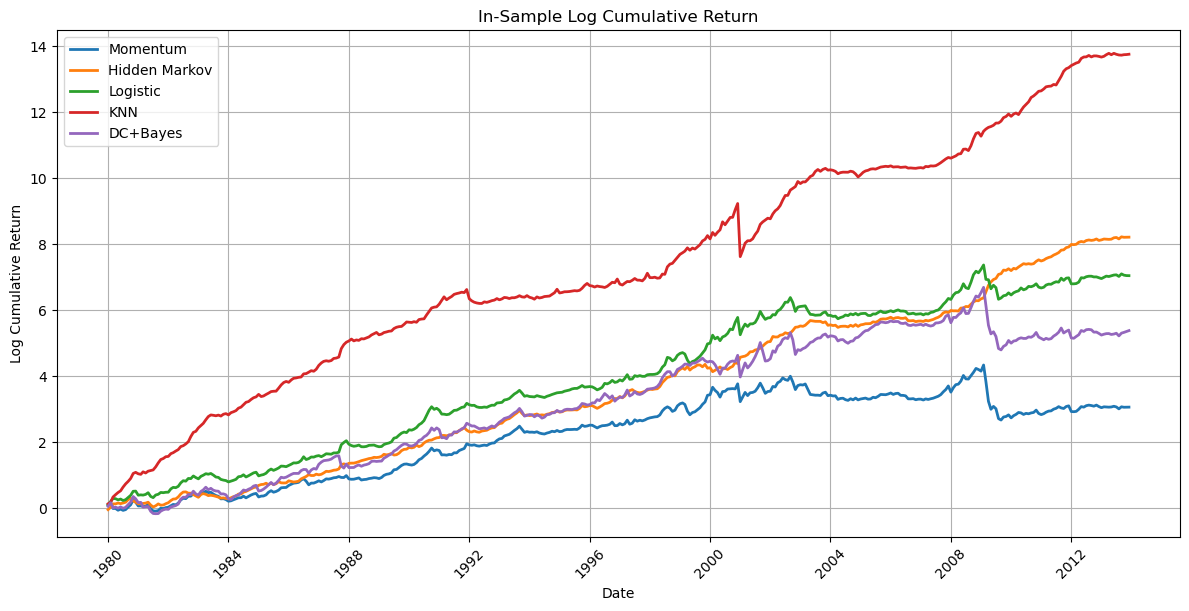

In [240]:
df = train_total.copy()
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['cum_MOM'], label='Momentum', linewidth=2)
plt.plot(df['Date'], df['cum_rtn'], label='Hidden Markov', linewidth=2)
plt.plot(df['Date'], df['Logistic'], label='Logistic', linewidth=2)
plt.plot(df['Date'], df['KNN'], label='KNN', linewidth=2)
plt.plot(df['Date'], df['DC_Bayes'], label='DC+Bayes', linewidth=2)
plt.title('In-Sample Log Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Log Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig("Return_In-sample.jpg", format='jpg', dpi=300, bbox_inches='tight')
plt.show()

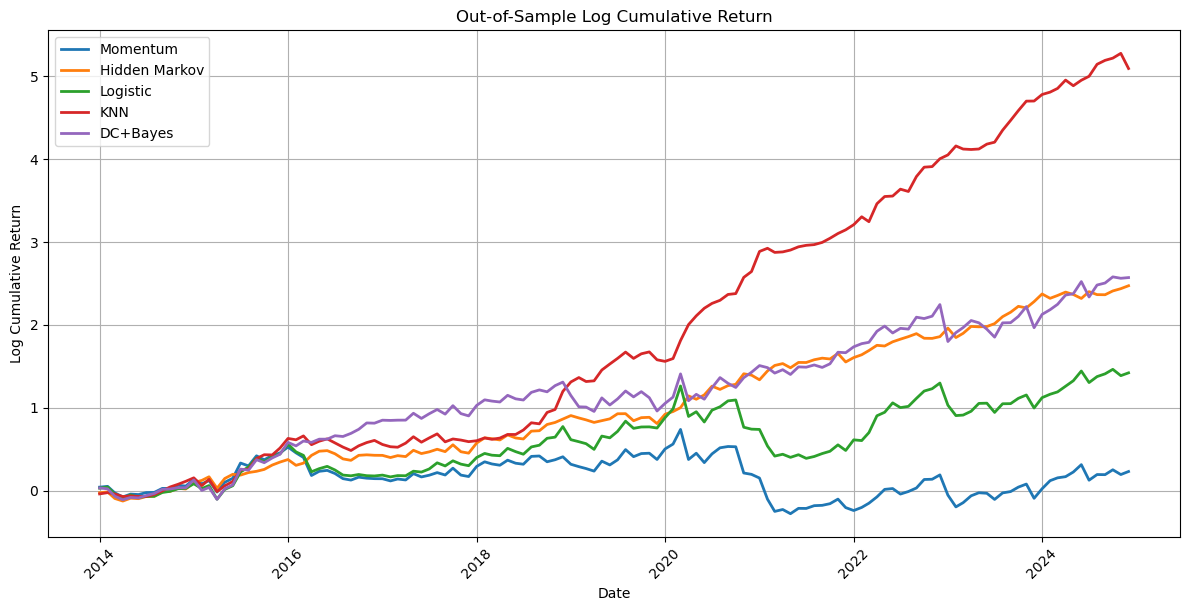

In [242]:
df = test_total.copy()
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['cum_MOM'], label='Momentum', linewidth=2)
plt.plot(df['Date'], df['cum_rtn'], label='Hidden Markov', linewidth=2)
plt.plot(df['Date'], df['Logistic'], label='Logistic', linewidth=2)
plt.plot(df['Date'], df['KNN'], label='KNN', linewidth=2)
plt.plot(df['Date'], df['DC_Bayes'], label='DC+Bayes', linewidth=2)
plt.title('Out-of-Sample Log Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Log Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig("Return_Out-of-sample.jpg", format='jpg', dpi=300, bbox_inches='tight')
plt.show()